In [1]:
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Task 1 : Visualize the images and create the atlases

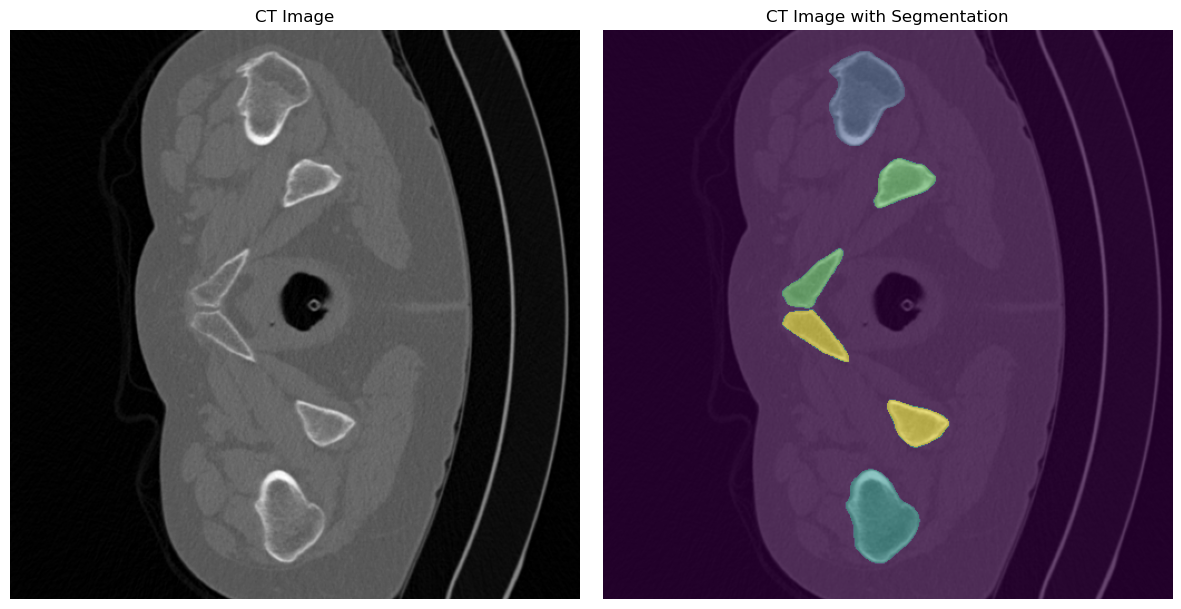

In [2]:
# Path to the NIfTI files
ct_image_path = r"Dataset\COMMON_images_masks\common_40_image.nii" 
mask_path = r"Dataset\COMMON_images_masks\common_40_mask.nii"
# ct_image_path = r"Dataset\GROUP_images\g1_54_image.nii"

ct_image = nib.load(ct_image_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

def visualize_slice_and_mask(ct_image, mask, slice_idx):
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.imshow(mask[:, :, slice_idx], alpha=0.5)
    plt.title("CT Image with Segmentation")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


slice_idx = ct_image.shape[2] // 2 -100
visualize_slice_and_mask(ct_image, mask, slice_idx)


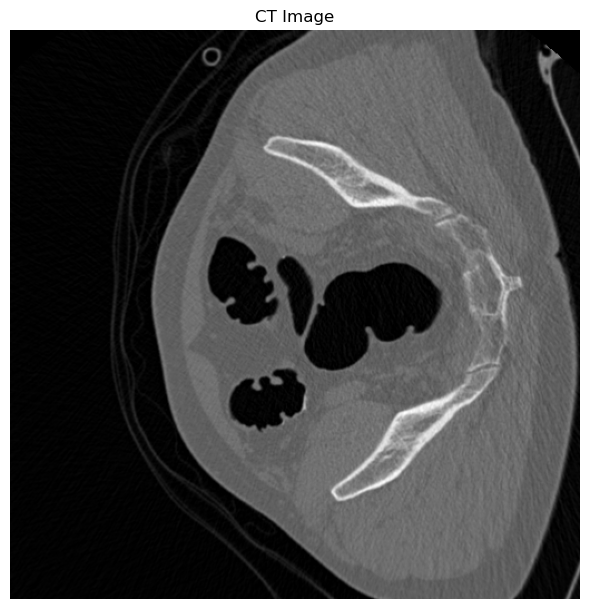

In [3]:
def visualize_slice(ct_image, slice_idx):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

ct_image_path = r"Dataset\GROUP_images\g1_55_image.nii" 
ct_image = nib.load(ct_image_path).get_fdata()
slice_idx = ct_image.shape[2] // 2
visualize_slice(ct_image,slice_idx)

# There is two types of dataset :

* First one : COMMON => 3 patients/CT scans that are already segmented => We have to segment the left femur and hip bones

* Second one : GROUP => We can take groupe 1 files = 3 patients/CT scans : they are not segmented at all, we have to do the segmentation manually

In [5]:
import os

common_dir = r"Dataset\COMMON_images_masks" 
output_dir = r"Dataset\Output_mask"  

os.makedirs(output_dir, exist_ok=True)


LEFT_FEMUR = 2  
LEFT_HIP_BONE = 4  
RIGHT_HIP_BONE = 3

mask_files = [f for f in os.listdir(common_dir) if "_mask.nii" in f]

# Processus de segmentation
for mask_file in mask_files:
    print(f"Traitement du fichier {mask_file}...")
    
    
    mask_path = os.path.join(common_dir, mask_file)
    mask_nii = nib.load(mask_path)
    mask_data = mask_nii.get_fdata()
    
    
    new_mask = np.zeros_like(mask_data)
    new_mask[mask_data == LEFT_FEMUR] = 1  
    new_mask[mask_data == LEFT_HIP_BONE] = 2 
    new_mask[mask_data == RIGHT_HIP_BONE] = 3
    
    # Enregistrer le nouveau masque
    new_mask_nii = nib.Nifti1Image(new_mask, mask_nii.affine, mask_nii.header)
    output_path = os.path.join(output_dir, f"filtered_{mask_file}")
    nib.save(new_mask_nii, output_path)
    print(f"Masque filtré enregistré : {output_path}")


Traitement du fichier common_40_mask.nii...


KeyboardInterrupt: 

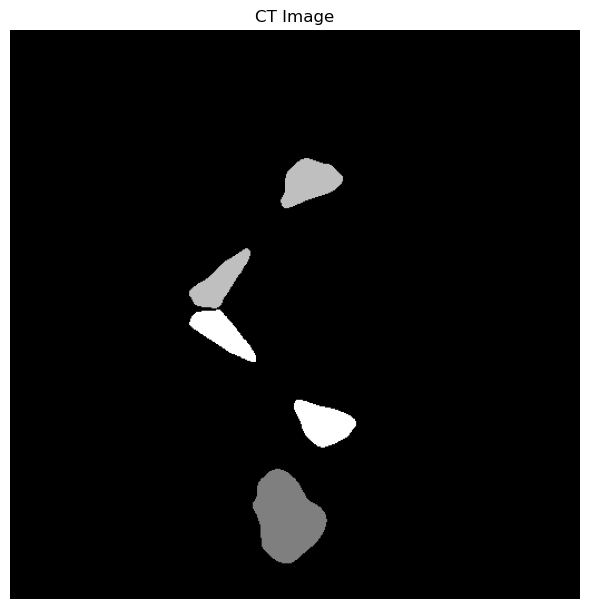

NameError: name 'visualize_slice_and_mask' is not defined

In [2]:
def visualize_slice(ct_image, slice_idx):
    plt.figure(figsize=(12, 6))

    # CT Image
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

ct_image_path = r"Dataset\Output_mask\filtered_common_40_mask.nii.gz" 
ct_image = nib.load(ct_image_path).get_fdata()
slice_idx = ct_image.shape[2] // 2 -100
visualize_slice(ct_image,slice_idx)
ct_image_path = r"Dataset\COMMON_images_masks\common_40_image.nii" 
ct_image = nib.load(ct_image_path).get_fdata()
mask_path = r"Dataset\COMMON_images_masks\common_40_mask.nii"
mask = nib.load(mask_path).get_fdata()
visualize_slice_and_mask(ct_image, mask, slice_idx)

# Task 2: Create the functions for registration (other file)

# Task 3: Atlas-based segmentation

In [2]:
import Codes.Registration as reg

In [3]:
# Helper functions

def numpy_to_sitk(mask_array, reference_image):
    """
    Convert a binary Numpy mask to a SimpleITK image.
    
    Parameters:
    - mask_array: The Numpy array representing the mask (binary).
    - reference_image: A SimpleITK image that defines the geometry of the mask
    
    Returns:
    - SimpleITK mask image
    """
    # Ensure the mask is binary (0 or 1)
    mask_array = np.round(mask_array).astype(np.uint8)
    
    # Convert the Numpy array to a SimpleITK image
    mask_sitk = sitk.GetImageFromArray(mask_array)
    
    # Set the spatial properties (spacing, origin, direction) to match the reference image
    mask_sitk.SetSpacing(reference_image.GetSpacing())
    mask_sitk.SetOrigin(reference_image.GetOrigin())
    mask_sitk.SetDirection(reference_image.GetDirection())
    
    return mask_sitk

def visualize_slice(ct_image, slice_idx):
    plt.figure(figsize=(12, 6))

    # CT Image
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## a) Registration of the group images on the common_40 

In [4]:
# Load the images
ref_image_path = r"Dataset\COMMON_images_masks\common_40_image.nii"
ref_image = sitk.ReadImage(ref_image_path,sitk.sitkFloat32)
x,y,_ = ref_image.GetOrigin()
ref_image.SetOrigin([x,y,0])

moving_image_paths = [r"Dataset/GROUP_images/g1_53_image.nii",
                      r"Dataset/GROUP_images/g1_54_image.nii",
                      r"Dataset/GROUP_images/g1_55_image.nii"]
moving_images = []
for moving_image_path in moving_image_paths:
    moving_image = sitk.ReadImage(moving_image_path,sitk.sitkFloat32)
    x,y,_ = moving_image.GetOrigin()
    moving_image.SetOrigin([x,y,0])
    moving_images.append(moving_image)

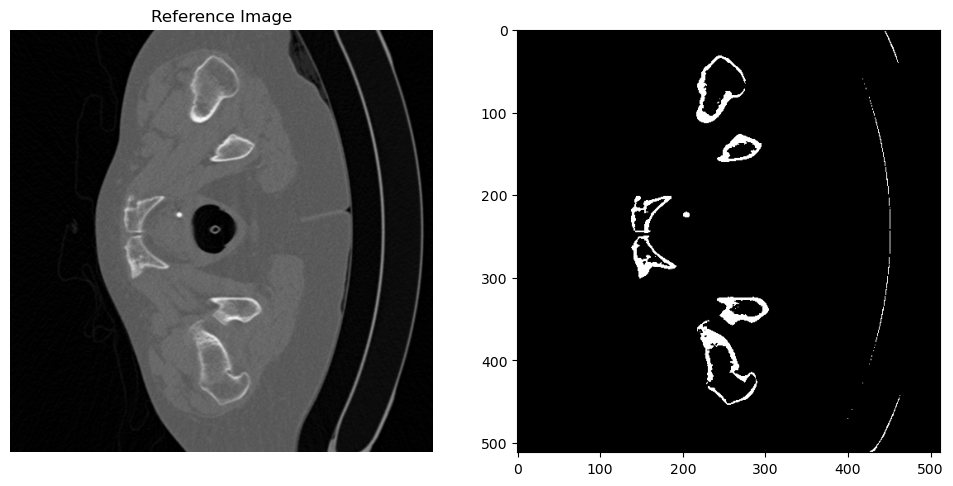

In [5]:
# Create the bone mask for the reference image
ref_array = sitk.GetArrayFromImage(ref_image)
ref_array = ref_array.swapaxes(0, 2)
mask = np.logical_and(ref_array>300,ref_array<3000) # Hounsfield values for bones : 300-3000
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(ref_array[:, :, ref_array.shape[2]//2 - 100], cmap="gray")
plt.title("Reference Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(mask[:, :, ref_array.shape[2]//2 - 100], cmap="gray")

sitk_mask = numpy_to_sitk(mask.swapaxes(0,2), ref_image)

In [6]:
# Find the transformations for the moving images, for now, only linear transformations
transformations = []
for i,moving_image in enumerate(moving_images):
    print(f"Aligning image g1_{i+53}...")
    moving_image = sitk.Resample(moving_image, ref_image.GetSize(), sitk.Transform(), sitk.sitkLinear, ref_image.GetOrigin(), ref_image.GetSpacing(), ref_image.GetDirection(), 0.0, moving_image.GetPixelID()) # Resample the moving image to match the reference image
    transformation = reg.est_lin_transf(ref_image, moving_image, sitk_mask, verbose = True)
    transformations.append(transformation)

Aligning image g1_53...
--------
Affine registration:
Final metric value: 389156.60673938436
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 28.
--------
Aligning image g1_54...
--------
Affine registration:
Final metric value: 331063.7552668469
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 55.
--------
Aligning image g1_55...
--------
Affine registration:
Final metric value: 380879.70570682216
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 30.
--------


In [7]:
# Save the transformed aligned images
for i, transformation in enumerate(transformations):
    print(f"Saving transformed image g1_{i+53}...")
    transformed_image = sitk.Resample(moving_images[i], ref_image.GetSize(), sitk.Transform(), sitk.sitkLinear, ref_image.GetOrigin(), ref_image.GetSpacing(), ref_image.GetDirection(), 0.0, moving_images[i].GetPixelID())
    transformed_image = reg.apply_lin_transf(transformed_image, transformation)
    sitk.WriteImage(transformed_image, f"Temp_files/pre_aligned_g1_{i+53}_image.nii")
    sitk.WriteTransform(transformation, f"Temp_files/pre_aligned_g1_{i+53}_transformation.tfm")

Saving transformed image g1_53...
Saving transformed image g1_54...
Saving transformed image g1_55...


In [8]:
# Load the pre-aligned images
moving_image_paths = [r"Temp_files/pre_aligned_g1_53_image.nii",
                        r"Temp_files/pre_aligned_g1_54_image.nii",
                        r"Temp_files/pre_aligned_g1_55_image.nii"]
moving_images = []
for moving_image_path in moving_image_paths:
    moving_image = sitk.ReadImage(moving_image_path,sitk.sitkFloat32)
    x,y,_ = moving_image.GetOrigin()
    moving_image.SetOrigin([x,y,0])
    moving_images.append(moving_image)

In [9]:
# Align the pre-aligned images using non-linear transformations
transformations_nl = []
for i,moving_image in enumerate(moving_images):
    print(f"Aligning image g1_{i+53}...")
    # moving_image = sitk.Resample(moving_image, ref_image.GetSize(), sitk.Transform(), sitk.sitkLinear, ref_image.GetOrigin(), ref_image.GetSpacing(), ref_image.GetDirection(), 0.0, moving_image.GetPixelID()) # Resample the moving image to match the reference image
    transformation_nl = reg.est_nl_transf(ref_image, moving_image, sitk_mask, verbose = True)
    transformations_nl.append(transformation_nl)

Aligning image g1_53...
--------
Non-linear registration:
Final metric value: -0.09758571937801877
Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 37 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).
Final Iteration: 37
--------
Aligning image g1_54...
--------
Non-linear registration:
Final metric value: -0.04142433845857715
Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 360 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).
Final Iteration: 360
--------
Aligning image g1_55...
--------
Non-linear registration:
Final metric value: -0.051301077496005085
Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 144 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e

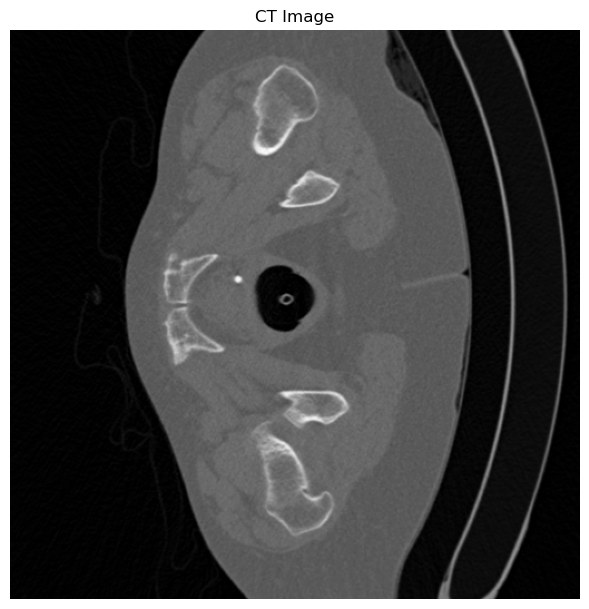

Plotting transformed image g1_53...


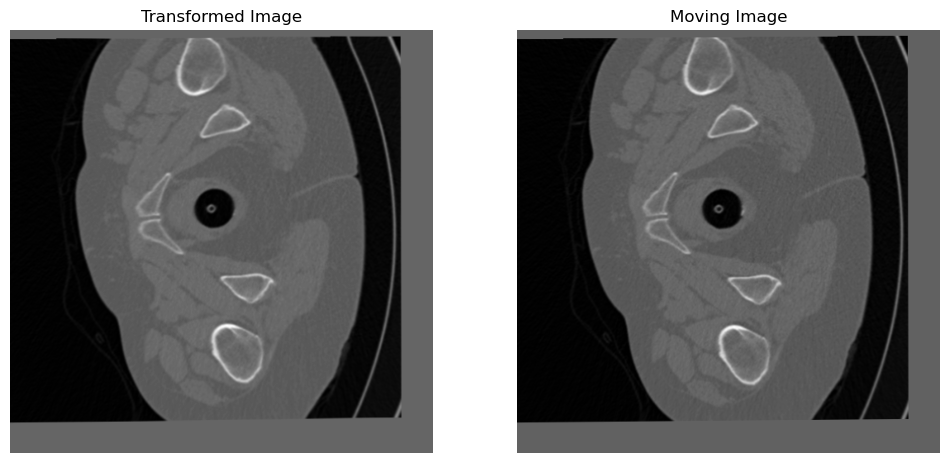

Plotting transformed image g1_54...


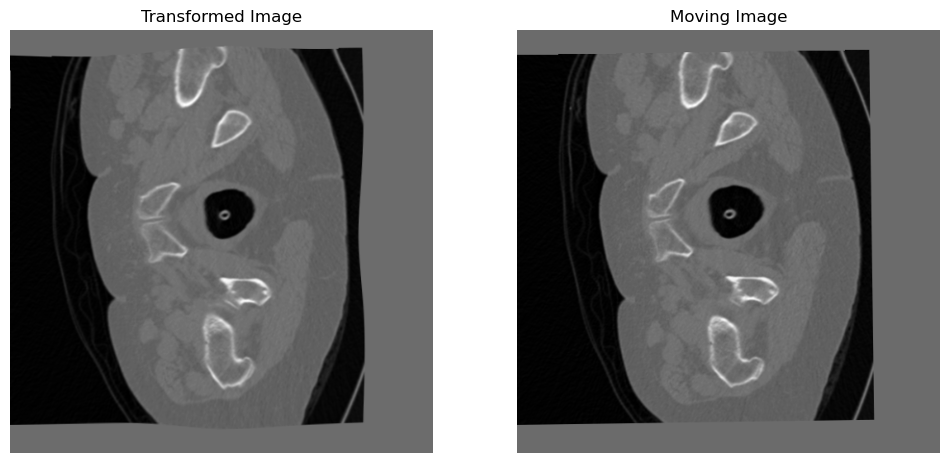

Plotting transformed image g1_55...


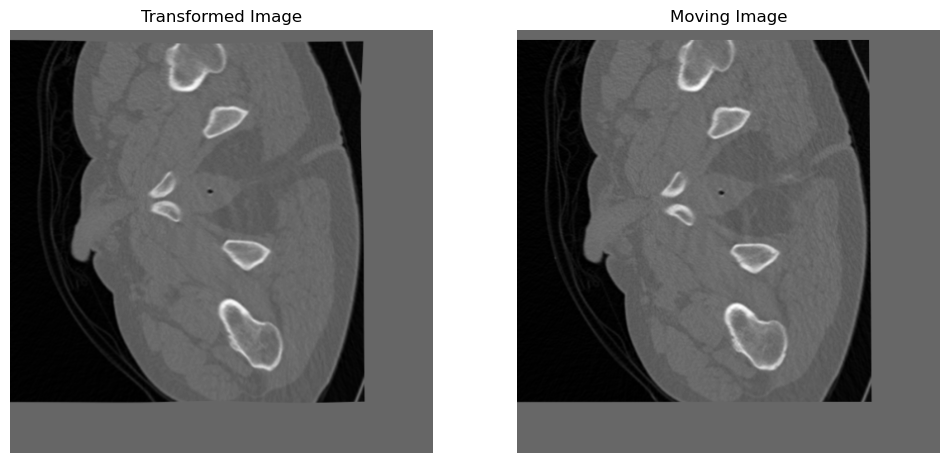

In [10]:
# Plot the transformations to check the results
ref_array = sitk.GetArrayFromImage(ref_image)
ref_array = ref_array.swapaxes(0, 2)
slice = ref_array.shape[2] // 2-100
visualize_slice(ref_array, slice)
for i, transformation in enumerate(transformations_nl):
    print(f"Plotting transformed image g1_{i+53}...")
    transformed_image = sitk.Resample(moving_images[i], ref_image.GetSize(), sitk.Transform(), sitk.sitkLinear, ref_image.GetOrigin(), ref_image.GetSpacing(), ref_image.GetDirection(), 0.0, moving_images[i].GetPixelID())
    transformed_image = reg.apply_lin_transf(transformed_image, transformation)
    transformed_array = sitk.GetArrayFromImage(transformed_image)
    transformed_array = transformed_array.swapaxes(0, 2)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(transformed_array[:, :, slice], cmap="gray")
    plt.title("Transformed Image")
    plt.axis("off")
    moving_array = sitk.GetArrayFromImage(moving_images[i])
    moving_array = moving_array.swapaxes(0, 2)
    plt.subplot(1, 2, 2)
    plt.imshow(moving_array[:, :, slice], cmap="gray")
    plt.title("Moving Image")
    plt.axis("off")
    plt.show()

In [8]:
transformations[0].GetParameters()

(1.0251457191848705,
 0.01526969766611313,
 0.051345198051911366,
 0.010019950781248885,
 1.0009592893386623,
 0.011070435247791315,
 -0.009584599976994361,
 0.00221485245956258,
 0.9852828303956046,
 -7.949587181741725,
 1.5069035554788284,
 7.390839625337609)

## b) Transform the masks and do a majority voting for segmentation

In [4]:
# Helper functions

def convert_mask_to_sitk(mask, reference_image):
    """
    Convert a mask loaded with nibabel into a SimpleITK image.
    
    Parameters:
    - mask_filename: Path to the mask file (e.g., .nii or .nii.gz)
    - reference_image: A SimpleITK image that defines the geometry of the mask
    
    Returns:
    - SimpleITK mask image
    """
    # Ensure that the mask is binary (0 or 1)
    mask = np.round(mask).astype(np.uint8)
    print(np.unique(mask))
    
    # Convert the Numpy array to a SimpleITK image
    mask_sitk = sitk.GetImageFromArray(mask)
    
    # Match the SimpleITK image's spacing and origin to the reference image
    mask_sitk.SetSpacing(reference_image.GetSpacing())
    mask_sitk.SetOrigin(reference_image.GetOrigin())
    mask_sitk.SetDirection(reference_image.GetDirection())
    
    return mask_sitk

In [12]:
# Load the masks
moving_image_paths = [r"Dataset/GROUP_images/g1_53_image.nii",
                      r"Dataset/GROUP_images/g1_54_image.nii",
                      r"Dataset/GROUP_images/g1_55_image.nii"]
moving_images = []
for moving_image_path in moving_image_paths:
    moving_image = sitk.ReadImage(moving_image_path,sitk.sitkFloat32)
    x,y,_ = moving_image.GetOrigin()
    moving_image.SetOrigin([x,y,0])
    moving_images.append(moving_image)

    
mask_paths = [r"Dataset\GROUP_images\g1_53_merged_masks.nii.gz",
                r"Dataset\GROUP_images\g1_54_merged_masks.nii.gz",
                r"Dataset\GROUP_images\g1_55_merged_masks.nii.gz"]
masks = []
for i,mask_path in enumerate(mask_paths):
    mask = nib.load(mask_path).get_fdata()
    mask = mask.swapaxes(0, 2)
    mask = convert_mask_to_sitk(mask, moving_images[i])
    masks.append(mask)

[  0 254 255]
[  0 254 255]
[  0 254 255]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


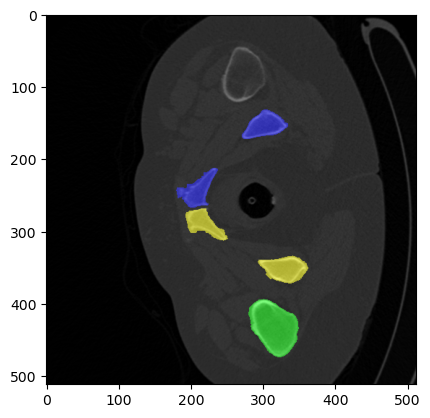

In [11]:
mask = nib.load(mask_paths[0]).get_fdata()
moving_array = sitk.GetArrayFromImage(moving_images[0])
moving_array = moving_array.swapaxes(0, 2)
plt.imshow(moving_array[:, :, moving_array.shape[2] // 2-100], cmap="gray")
plt.imshow(mask[:,:,mask.shape[2]//2-100], alpha=0.5)

In [13]:
# Apply the transformations to the masks
transformed_masks = []
for i,mask in enumerate(masks):
    print(f"Transforming mask g1_{i+53} with size {mask.GetSize()}...")
    mask =  sitk.Resample(mask, ref_image.GetSize(), sitk.Transform(), sitk.sitkLinear, ref_image.GetOrigin(), ref_image.GetSpacing(), ref_image.GetDirection(), 0.0, mask.GetPixelID())
    print(mask.GetSize())
    transformed_mask = reg.apply_lin_transf(mask, transformations[i])
    transformed_mask = reg.apply_nl_transf(transformed_mask, transformations_nl[i])
    transformed_masks.append(transformed_mask)

Transforming mask g1_53 with size (512, 512, 311)...
(512, 512, 291)
Transforming mask g1_54 with size (512, 512, 276)...
(512, 512, 291)
Transforming mask g1_55 with size (512, 512, 301)...
(512, 512, 291)


(512, 512, 291, 3)


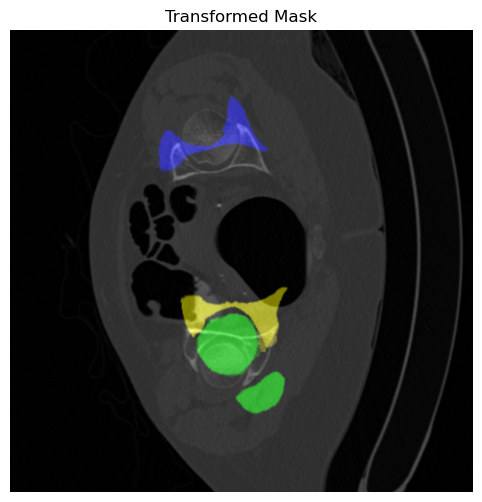

(512, 512, 291, 3)


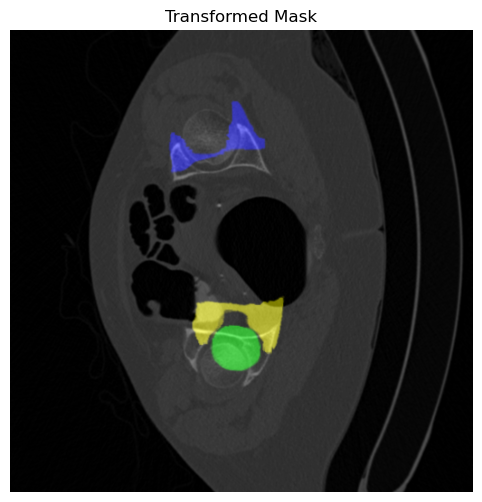

(512, 512, 291, 3)


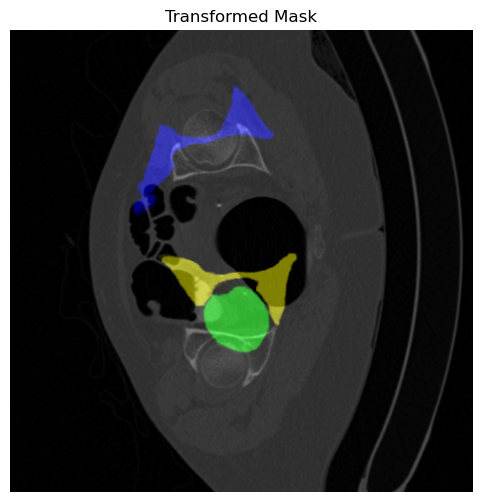

In [14]:
# Print the 3 masks to check the results
for i,t_mask in enumerate(transformed_masks):
    t_mask_array = sitk.GetArrayFromImage(t_mask)
    t_mask_array = t_mask_array.swapaxes(0, 2)
    print(t_mask_array.shape)
    plt.figure(figsize=(12, 6))
    plt.imshow(ref_array[:, :, ref_array.shape[2] // 2-60], cmap="gray")
    plt.imshow(t_mask_array[:, :, ref_array.shape[2] // 2-60], alpha=0.5)
    plt.title("Transformed Mask")
    plt.axis("off")
    plt.show()

In [15]:
# Majority voting and save the results
final_masks = []
final_mask_y = np.zeros_like(ref_array)
final_mask_g = np.zeros_like(ref_array)
final_mask_b = np.zeros_like(ref_array)
for i,t_mask in enumerate(transformed_masks):
    print(f"Processing mask g1_{i+53} of shape {t_mask.GetSize()}...")
    t_mask_array = sitk.GetArrayFromImage(t_mask)
    t_mask_array = t_mask_array.swapaxes(0, 2)
    t_mask_array = np.where(t_mask_array==254, 255, t_mask_array)
    t_mask_array = np.where(t_mask_array!=255, 0, t_mask_array)
    final_mask_y += (t_mask_array == np.array([255,255,0])).all(axis= 3)
    final_mask_g += (t_mask_array == np.array([0,255,0])).all(axis= 3)
    final_mask_b += (t_mask_array == np.array([0,0,255])).all(axis= 3)

final_mask_y = np.where(final_mask_y>1, 3, 0)
final_mask_g = np.where(final_mask_g>1, 2, 0)
final_mask_b = np.where(final_mask_b>1, 1, 0)
final_mask = final_mask_y + final_mask_g + final_mask_b
final_masks.append(final_mask)

Processing mask g1_53 of shape (512, 512, 291)...
Processing mask g1_54 of shape (512, 512, 291)...
Processing mask g1_55 of shape (512, 512, 291)...


In [15]:
np.unique(final_mask)

array([0, 1, 2, 3])

In [16]:
final_mask_sitk = convert_mask_to_sitk(final_mask, ref_image)
writer = sitk.ImageFileWriter()
writer.SetFileName(r"Dataset\Output_mask\nl_lin_mask_40.nii.gz")
writer.Execute(final_mask_sitk)

[0 1 2 3]


## c) Do the same for common_41 and common_42

In [5]:
# Do task 3.a and 3.b in one function
def seg_atlas(ref_image_path, moving_image_paths, mask_paths):
    # Load the images
    ref_image = sitk.ReadImage(ref_image_path,sitk.sitkFloat32)
    x,y,_ = ref_image.GetOrigin()
    ref_image.SetOrigin([x,y,0])

    moving_images = []
    for moving_image_path in moving_image_paths:
        moving_image = sitk.ReadImage(moving_image_path,sitk.sitkFloat32)
        x,y,_ = moving_image.GetOrigin()
        moving_image.SetOrigin([x,y,0])
        moving_images.append(moving_image)

    # Create the bone mask for the reference image
    ref_array = sitk.GetArrayFromImage(ref_image)
    ref_array = ref_array.swapaxes(0, 2)
    mask = np.logical_and(ref_array>300,ref_array<3000) # Hounsfield values for bones : 300-3000
    sitk_mask = numpy_to_sitk(mask.swapaxes(0,2), ref_image)

    # Find the transformations for the moving images, for now, only linear transformations
    transformations = []
    for i,moving_image in enumerate(moving_images):
        print(f"Aligning image g1_{i+53}...")
        moving_image = sitk.Resample(moving_image, ref_image.GetSize(), sitk.Transform(), sitk.sitkLinear, ref_image.GetOrigin(), ref_image.GetSpacing(), ref_image.GetDirection(), 0.0, moving_image.GetPixelID()) # Resample the moving image to match the reference image
        transformation = reg.est_lin_transf(ref_image, moving_image, sitk_mask, verbose = True)
        transformations.append(transformation)
        moving_images[i] = reg.apply_lin_transf(moving_image, transformation)

    transformations_nl = []
    for i,moving_image in enumerate(moving_images):
        print(f"Aligning image g1_{i+53}...")
        transformation_nl = reg.est_nl_transf(ref_image, moving_image, sitk_mask, verbose = True)
        transformations_nl.append(transformation_nl)

    # Load the masks
    masks = []
    for i,mask_path in enumerate(mask_paths):
        mask = nib.load(mask_path).get_fdata()
        mask = mask.swapaxes(0, 2)
        mask = convert_mask_to_sitk(mask, moving_images[i])
        masks.append(mask)
    
    # Apply the transformations to the masks
    transformed_masks = []
    for i,mask in enumerate(masks):
        print(f"Transforming mask g1_{i+53} with size {mask.GetSize()}...")
        mask =  sitk.Resample(mask, ref_image.GetSize(), sitk.Transform(), sitk.sitkLinear, ref_image.GetOrigin(), ref_image.GetSpacing(), ref_image.GetDirection(), 0.0, mask.GetPixelID())
        print(mask.GetSize())
        transformed_mask = reg.apply_lin_transf(mask, transformations[i])
        transformed_mask = reg.apply_nl_transf(transformed_mask, transformations_nl[i])
        transformed_masks.append(transformed_mask)
    
    # Majority voting and save the results
    final_mask_y = np.zeros_like(ref_array)
    final_mask_g = np.zeros_like(ref_array)
    final_mask_b = np.zeros_like(ref_array)
    for i,t_mask in enumerate(transformed_masks):
        print(f"Processing mask g1_{i+53} of shape {t_mask.GetSize()}...")
        t_mask_array = sitk.GetArrayFromImage(t_mask)
        t_mask_array = t_mask_array.swapaxes(0, 2)
        t_mask_array = np.where(t_mask_array==254, 255, t_mask_array)
        t_mask_array = np.where(t_mask_array!=255, 0, t_mask_array)
        final_mask_y += (t_mask_array == np.array([255,255,0])).all(axis= 3)
        final_mask_g += (t_mask_array == np.array([0,255,0])).all(axis= 3)
        final_mask_b += (t_mask_array == np.array([0,0,255])).all(axis= 3)
    
    final_mask_y = np.where(final_mask_y>1, 3, 0)
    final_mask_g = np.where(final_mask_g>1, 2, 0)
    final_mask_b = np.where(final_mask_b>1, 1, 0)
    final_mask = final_mask_y + final_mask_g + final_mask_b

    return final_mask

In [6]:
# Apply the function to common_41 and common_42
moving_image_paths = [r"Dataset\GROUP_images\g1_53_image.nii",
                      r"Dataset\GROUP_images\g1_54_image.nii",
                      r"Dataset\GROUP_images\g1_55_image.nii"]
mask_paths = [r"Dataset\GROUP_images\g1_53_merged_masks.nii.gz",
              r"Dataset\GROUP_images\g1_54_merged_masks.nii.gz",
              r"Dataset\GROUP_images\g1_55_merged_masks.nii.gz"]


ref_image_path1 = r"Dataset\COMMON_images_masks\common_41_image.nii"
final_mask = seg_atlas(ref_image_path1, moving_image_paths, mask_paths)

ref_image = sitk.ReadImage(ref_image_path1,sitk.sitkFloat32)
final_mask_sitk = convert_mask_to_sitk(final_mask, ref_image)
writer = sitk.ImageFileWriter()
writer.SetFileName(r"Dataset\Output_mask\nl_lin_mask_41.nii.gz")
writer.Execute(final_mask_sitk)


Aligning image g1_53...
--------
Affine registration:
Final metric value: 395598.251901731
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 29.
--------
Aligning image g1_54...
--------
Affine registration:
Final metric value: 272304.7024234335
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 57.
--------
Aligning image g1_55...
--------
Affine registration:
Final metric value: 285300.34239863
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 50.
--------
Aligning image g1_53...
--------
Non-linear registration:
Final metric value: -0.27107284345876526
Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 95 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).
Final Iteration: 95
--------
Aligning image g1_54...
---

# Task 4: Accuracy assessment

In [19]:
mask = nib.load(f"Dataset/COMMON_images_masks/common_40_mask.nii").get_fdata()

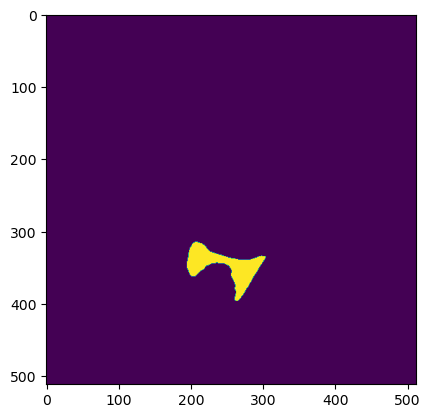

In [41]:
plt.imshow((mask*(mask==4))[:,:,mask.shape[2]//2-60])

Correspondancies segmentation between manual - atlas

3 - 1 : right hip bone

2 - 2 : left hip bone

4 - 3 : left femur

In [5]:
# Create a function to compute the scores
def compute_scores(mask, reference_mask):
    """
    Compute the Dice score and Hausdorff distance between two masks using sitk functions.
    
    Parameters:
    - mask: The predicted mask
    - reference_mask: The ground truth mask
    
    Returns:
    - Dice score
    - Hausdorff distance
    """
    # Compute the Dice score
    overlap_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_filter.Execute(reference_mask, mask)
    dice_score = overlap_filter.GetDiceCoefficient()
    
    # Compute the Hausdorff distance
    hausdorff_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_filter.Execute(reference_mask, mask)
    hausdorff_distance = hausdorff_filter.GetHausdorffDistance()
    
    return dice_score, hausdorff_distance

In [6]:
for i in range(3):
    ref_mask = nib.load(f"Dataset/COMMON_images_masks/common_{i+40}_mask.nii").get_fdata()
    atlas_mask = nib.load(f"Dataset/Output_mask/nl_lin_mask_{i+40}.nii.gz").get_fdata().swapaxes(0,2)
    ref_image = sitk.ReadImage(f"Dataset/COMMON_images_masks/common_{i+40}_image.nii",sitk.sitkFloat32)
    # For left femur
    mask_f = np.where(atlas_mask==3, 1, 0)
    ref_f = np.where(ref_mask==4, 1, 0)
    d_s, h_d = compute_scores(numpy_to_sitk(mask_f, ref_image), numpy_to_sitk(ref_f, ref_image))
    print(f"Common_{i+40} - Left femur : Dice score = {d_s}, Hausdorff distance = {h_d}")
    print("-----")
    # For left hip bone
    mask_lh = np.where(atlas_mask==2, 1, 0)
    ref_lh = np.where(ref_mask==2, 1, 0)
    d_s, h_d = compute_scores(numpy_to_sitk(mask_lh, ref_image), numpy_to_sitk(ref_lh, ref_image))
    print(f"Common_{i+40} - Left hip bone : Dice score = {d_s}, Hausdorff distance = {h_d}")
    print("-----")
    # For right hip bone
    mask_rh = np.where(atlas_mask==1, 1, 0)
    ref_rh = np.where(ref_mask==3, 1, 0)
    d_s, h_d = compute_scores(numpy_to_sitk(mask_rh, ref_image), numpy_to_sitk(ref_rh, ref_image))
    print(f"Common_{i+40} - Right hip bone : Dice score = {d_s}, Hausdorff distance = {h_d}")
    print("--------------------------------------------------------------------------------------")

Common_40 - Left femur : Dice score = 0.4864881368728419, Hausdorff distance = 28.621046824095952
-----
Common_40 - Left hip bone : Dice score = 0.22678095231578968, Hausdorff distance = 39.17174150177317
-----
Common_40 - Right hip bone : Dice score = 0.6239453877603783, Hausdorff distance = 20.22951655155071
--------------------------------------------------------------------------------------
Common_41 - Left femur : Dice score = 0.6996035268148564, Hausdorff distance = 22.76295454647336
-----
Common_41 - Left hip bone : Dice score = 0.6595803276358339, Hausdorff distance = 19.609334915241746
-----
Common_41 - Right hip bone : Dice score = 0.781907508081105, Hausdorff distance = 14.42150629645286
--------------------------------------------------------------------------------------
Common_42 - Left femur : Dice score = 0.05667609284883239, Hausdorff distance = 39.85644617389832
-----
Common_42 - Left hip bone : Dice score = 0.2959725401267842, Hausdorff distance = 33.53685765868701


In [8]:
ref_mask.shape, atlas_mask.shape

((512, 512, 286), (286, 512, 512))

# Task 5: Image classification

In [5]:
## Patient g1_53 de 81 à 38 sur 311
## Patient g1_54 de 66 à 27 sur 276
## Patient g1_55 de 81 à 31 sur 301

# List 1: 311 elements, indices 38 to 81 are 1, others are 0
list1 = [1 if 38 <= i <= 81 else 0 for i in range(311)]

# List 2: 276 elements, indices 27 to 66 are 1, others are 0
list2 = [1 if 27 <= i <= 66 else 0 for i in range(276)]

# List 3: 311 elements, indices 31 to 81 are 1, others are 0
list3 = [1 if 31 <= i <= 81 else 0 for i in range(301)]

# Print the lists to verify (optional)
print("List 1:", list1)
print("List 2:", list2)
print("List 3:", list3)

List 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
List 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [6]:
import nibabel as nib
import numpy as np

def load_nifti_slices(file_paths):
    """
    Charge des fichiers NIfTI et extrait chaque slice sagittale sous forme de tableau 2D.
    
    Args:
        file_paths (list): Liste des chemins des fichiers NIfTI.
        
    Returns:
        list: Liste contenant les slices 2D (format NumPy array) de tous les fichiers.
    """
    im_list = []

    for file_path in file_paths:
        # Charger le fichier NIfTI
        nifti_data = nib.load(file_path)
        volume = nifti_data.get_fdata()  # Récupérer les données en tant que tableau NumPy
        
        # Extraire les slices sagittales (axe 0)
        for slice_idx in range(volume.shape[2]):  # Axe 0 : Sagittal
            slice_2d = volume[:, :, slice_idx]  # Slice 2D (coronal et axial)
            im_list.append(slice_2d)
    
    return im_list

# Liste des fichiers NIfTI
nifti_files = [r"C:\Users\Serge\Documents\Projet3D_2\Dataset\GROUP_images\g1_53_image.nii.gz", r"C:\Users\Serge\Documents\Projet3D_2\Dataset\GROUP_images\g1_54_image.nii.gz", r"C:\Users\Serge\Documents\Projet3D_2\Dataset\GROUP_images\g1_55_image.nii.gz"]

# Charger les slices dans im_list
im_list = load_nifti_slices(nifti_files)

# Vérifier la longueur de im_list
print(f"Nombre total de slices chargées : {len(im_list)}")

Nombre total de slices chargées : 888


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np

def train_classifier(im_list, labels_list):
    """
    Receive a list of images `im_list` and a list of vectors (one
    per image) with the labels 0 or 1 depending on the axial 2D slice
    containing or not the pubic symphysis. Returns the trained classifier.
    """
    # Flatten images for SVM (if using simple models)
    im_flattened = [im.flatten() for im in im_list]
    
    # Flatten the labels list to a single vector
    labels_flattened = [label for labels in labels_list for label in labels]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        im_flattened, labels_flattened, test_size=0.2, random_state=42
    )
    
    # Train a simple SVM classifier
    classifier = SVC(kernel='linear', probability=True, random_state=42)
    classifier.fit(X_train, y_train)
    
    # Evaluate the classifier
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return classifier

labels_list = [list1, list2, list3]
classifier = train_classifier(im_list,labels_list)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       1.00      1.00      1.00        31

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



In [17]:
import matplotlib.pyplot as plt

def obturator_foramen_selection(test_image, classifier):
    """
    Selects the sagittal slice with the highest probability of containing
    the obturator foramen and plots the evolution of the probabilities.
    
    Args:
        test_image (numpy array): 3D array of the test image (sagittal slices).
        classifier (trained model): Trained classifier to estimate probabilities.
        
    Returns:
        int: Index of the sagittal slice with the highest probability.
        numpy array: Array of probabilities for each sagittal slice.
    """
    probabilities = []

    # Iterate through each sagittal slice and estimate the probability
    for slice_idx in range(test_image.shape[2]):  # Iterate over sagittal slices (axis 0)
        slice_2d = test_image[:, :, slice_idx]  # Extract a 2D slice
        slice_2d_flattened = slice_2d.flatten().reshape(1, -1)  # Flatten and reshape for the classifier
        prob = classifier.predict_proba(slice_2d_flattened)[0, 1]  # Probability for class "1"
        probabilities.append(prob)

    # Convert probabilities to a NumPy array
    probabilities = np.array(probabilities)

    # Find the index of the slice with the highest probability
    max_prob_idx = np.argmax(probabilities)

    # Plot the evolution of probabilities
    plt.figure(figsize=(10, 6))
    plt.plot(range(test_image.shape[2]), probabilities, marker="o")
    plt.axvline(max_prob_idx, color="red", linestyle="--", label=f"Max Probability at Slice {max_prob_idx}")
    plt.title("Estimated Probability of Containing the Obturator Foramen")
    plt.xlabel("Sagittal Slice Index (z-axis)")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

    return max_prob_idx, probabilities


In [18]:
import nibabel as nib
import numpy as np

# Load the NIfTI image
nifti_image = nib.load(r'C:\Users\Serge\Documents\Projet3D_2\Dataset\COMMON_images_masks\common_40_image.nii.gz')

# Get the image data as a 3D NumPy array (shape: [num_slices, height, width])
test_image = nifti_image.get_fdata()

# Verify the shape of the loaded image
print(test_image.shape)  # Should output (num_slices, height, width)

(512, 512, 286)


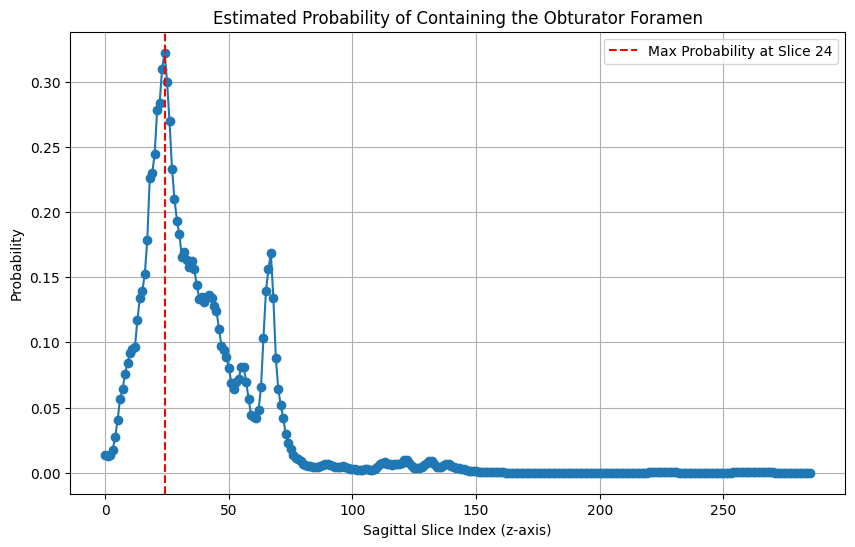

(np.int64(24),
 array([1.32338242e-02, 1.30820080e-02, 1.34790306e-02, 1.76950350e-02,
        2.71998250e-02, 4.06051741e-02, 5.64865154e-02, 6.39693915e-02,
        7.56865924e-02, 8.42574329e-02, 9.17108794e-02, 9.48204090e-02,
        9.64813567e-02, 1.17067968e-01, 1.34315507e-01, 1.39254390e-01,
        1.52596655e-01, 1.78355771e-01, 2.26329193e-01, 2.29725848e-01,
        2.44872701e-01, 2.78489949e-01, 2.83581320e-01, 3.09833533e-01,
        3.22193630e-01, 3.00062067e-01, 2.69539980e-01, 2.33086578e-01,
        2.09990165e-01, 1.93413224e-01, 1.82889692e-01, 1.65245770e-01,
        1.69413834e-01, 1.63071027e-01, 1.57649902e-01, 1.62111279e-01,
        1.56450306e-01, 1.43689795e-01, 1.33619007e-01, 1.35143832e-01,
        1.31322874e-01, 1.34755318e-01, 1.36290194e-01, 1.34130069e-01,
        1.28222777e-01, 1.23849044e-01, 1.10645985e-01, 9.72790861e-02,
        9.42397497e-02, 8.90068886e-02, 8.03716318e-02, 6.88625508e-02,
        6.43245524e-02, 6.96090157e-02, 7.2121966

In [19]:
obturator_foramen_selection(test_image,classifier)

(512, 512, 300)


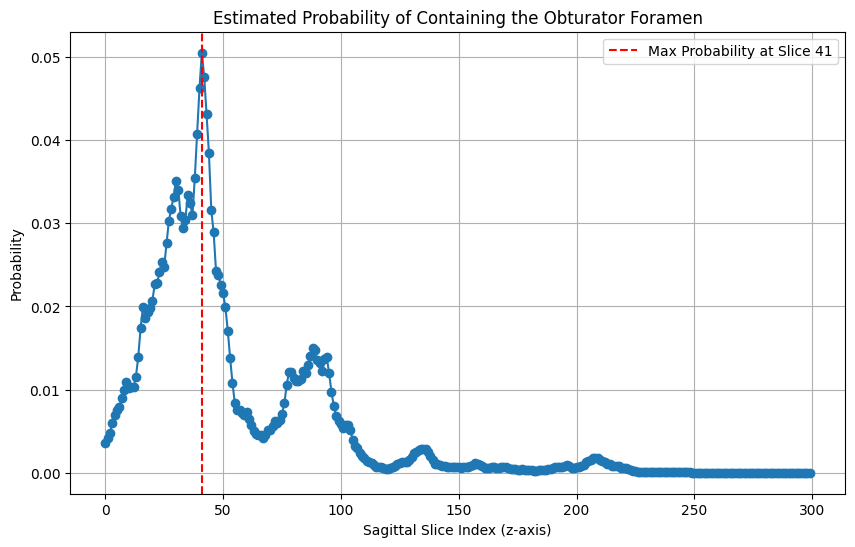

(np.int64(41),
 array([3.61661006e-03, 4.18124018e-03, 4.77558414e-03, 6.04840104e-03,
        7.00077206e-03, 7.53541893e-03, 7.90018851e-03, 9.01095948e-03,
        1.00007356e-02, 1.08675364e-02, 1.01942807e-02, 1.03225819e-02,
        1.03173197e-02, 1.15398099e-02, 1.39282788e-02, 1.73745601e-02,
        1.99928799e-02, 1.86656371e-02, 1.92972982e-02, 1.97588729e-02,
        2.07040587e-02, 2.26687114e-02, 2.27738958e-02, 2.40942139e-02,
        2.53505775e-02, 2.47931436e-02, 2.75682273e-02, 3.02895354e-02,
        3.17204528e-02, 3.31625104e-02, 3.51281838e-02, 3.40477554e-02,
        3.08213180e-02, 2.93740824e-02, 3.04194767e-02, 3.34300708e-02,
        3.24011448e-02, 3.09814096e-02, 3.54384210e-02, 4.07321854e-02,
        4.62650456e-02, 5.04979247e-02, 4.75519802e-02, 4.30909118e-02,
        3.84008260e-02, 3.15906665e-02, 2.88907164e-02, 2.42950033e-02,
        2.37358338e-02, 2.26086642e-02, 2.15642145e-02, 1.98957458e-02,
        1.70736208e-02, 1.37900941e-02, 1.0771408

In [21]:
nifti_image = nib.load(r'C:\Users\Serge\Documents\Projet3D_2\Dataset\COMMON_images_masks\common_41_image.nii.gz')

# Get the image data as a 3D NumPy array (shape: [num_slices, height, width])
test_image = nifti_image.get_fdata()

# Verify the shape of the loaded image
print(test_image.shape)  # Should output (num_slices, height, width)
obturator_foramen_selection(test_image,classifier)

(512, 512, 291)


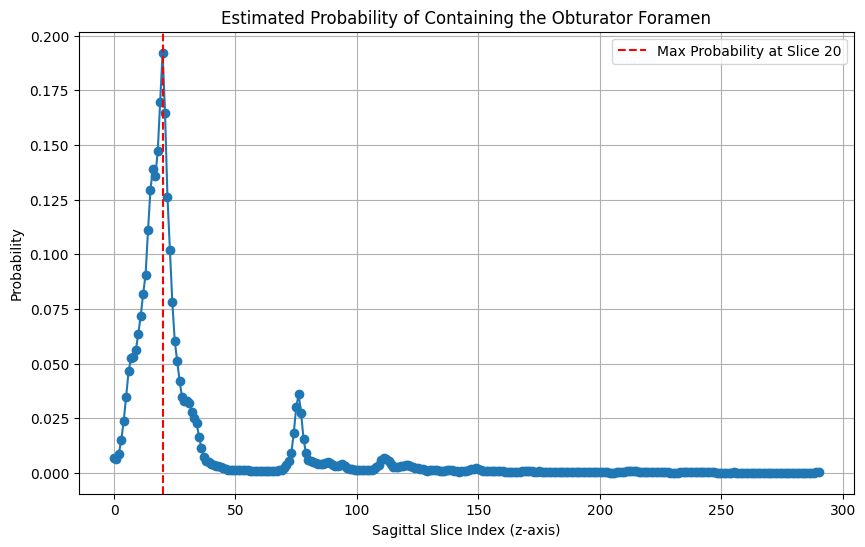

(np.int64(20),
 array([6.55702429e-03, 6.53090135e-03, 8.83257916e-03, 1.49985521e-02,
        2.38911110e-02, 3.48995021e-02, 4.64419364e-02, 5.23898592e-02,
        5.30631926e-02, 5.62921574e-02, 6.35497017e-02, 7.19655466e-02,
        8.19326724e-02, 9.06119442e-02, 1.10919923e-01, 1.29523030e-01,
        1.39105113e-01, 1.35595609e-01, 1.47119082e-01, 1.69856538e-01,
        1.92212979e-01, 1.64494355e-01, 1.26314914e-01, 1.01904871e-01,
        7.80693305e-02, 6.03616448e-02, 5.13105055e-02, 4.20132747e-02,
        3.45243481e-02, 3.29386162e-02, 3.28312754e-02, 3.18158387e-02,
        2.77210253e-02, 2.48808067e-02, 2.29352153e-02, 1.64168725e-02,
        1.11780562e-02, 7.33891980e-03, 5.30679894e-03, 4.93301555e-03,
        4.16175945e-03, 3.38489428e-03, 3.16772796e-03, 3.08222306e-03,
        2.62443910e-03, 2.12673561e-03, 1.77374579e-03, 1.39121735e-03,
        1.20478589e-03, 1.17324355e-03, 1.19071989e-03, 1.14114916e-03,
        1.15324766e-03, 1.15935963e-03, 1.2456318

In [22]:
nifti_image = nib.load(r'C:\Users\Serge\Documents\Projet3D_2\Dataset\COMMON_images_masks\common_42_image.nii.gz')

# Get the image data as a 3D NumPy array (shape: [num_slices, height, width])
test_image = nifti_image.get_fdata()

# Verify the shape of the loaded image
print(test_image.shape)  # Should output (num_slices, height, width)
obturator_foramen_selection(test_image,classifier)